In [1]:
import numpy as np
import matplotlib.pyplot as plt
import analyze
from analyze import CallAggregator
from scipy import interpolate

In [22]:
data = analyze.load_pickle()

In [4]:
print(data.keys())

dict_keys(['nloci', 'ncalls', 'ncorrect_unphased', 'ncorrect_phased', 'ncalls_not_in_ref', 'sample_acc', 'loci_acc', 'unphased_call_calibration', 'phased_call_calibration'])


# Analysis of unphased calls

Total calls: 9716850
Overall accuracy: 91.90%


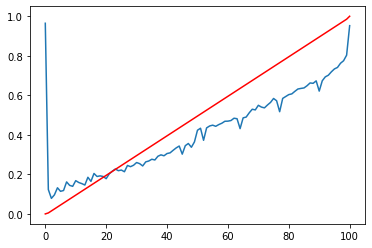

In [46]:
print("Total calls: {}".format(data['ncalls']))
print("Overall accuracy: {:.2%}".format(data['ncorrect_unphased']/data['ncalls']))

ucc = data['unphased_call_calibration']
results = []
call_iter = iter(ucc.call_bins.values())
success_iter = iter(ucc.success_bins.values())
while True:
    call_num = next(call_iter, None)
    success_num = next(success_iter, None)
    if call_num is None:
        break
    if call_num == 0:
        continue
    results.append(success_num/call_num)
plt.plot(range(len(results)), results)
expectedResults = [0]
for idx in list(ucc.call_bins.keys())[1:-2]:
    expectedResults.append(idx + ucc.bin_size/2)
expectedResults.append(1)
plt.plot(range(len(results)), expectedResults, 'r')

In [47]:
set([1,2])

{1, 2}

In [ ]:
#reference
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep
#can't get this to work ...
#maybe because there are duplicate x values?
#maybe because the x-values aren't sorted?
ucc = data['unphased_call_calibration']
spline = interpolate.splrep(ucc.calls[:ucc.ncalls], np.array(ucc.call_successes[:ucc.ncalls], dtype=float), s = 100000, xb=0, xe=1)
xs = np.linspace(0, 1, 1000)
ys = interpolate.splev(xs, spline)
plt.plot(xs, ys)